In [1]:
import numpy as np
import pandas as pd
import torch
from torch.nn import CrossEntropyLoss
import matplotlib.pyplot as plt
cmap = plt.get_cmap("viridis")

import config as u_config
from graph_models import FullGraphModel

from data_processing import CompleteModelsDataProcessor
from manifold_funcs import manifold_test, extract_details
from manifold_plots import create_dash_app_two_sliders


device_type = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device_type)
dtype = torch.float32
batch_size = u_config.batch_size

In [3]:
data_processor = CompleteModelsDataProcessor(u_config)
model = FullGraphModel(data_processor, u_config).to(device)
criterion = CrossEntropyLoss()

checkpoint = torch.load(
    "models/m_2024-07-24 17:10_xv8naljn.pth",  # for points
    map_location=device_type,
)
model.load_state_dict(checkpoint["model"])
torch.set_grad_enabled(False)
model.eval()

FullGraphModel(
  (connectome): Connectome()
  (final_fc): Linear(in_features=1, out_features=2, bias=True)
  (decision_making_dropout): Dropout(p=0, inplace=False)
)

In [4]:
test_results, final_plots, accuracy, intermediate, labels = manifold_test(
    model, data_processor, criterion, device, u_config
)

  0%|          | 0/225 [00:00<?, ?it/s]

100%|██████████| 225/225 [16:48<00:00,  4.48s/it]


Finished testing with loss 70848.45487323985 and accuracy 0.7304166666666667.


In [5]:
intermediate = intermediate.cpu().numpy()

test_results["colour"] = test_results["Image"].str.split("/").str.get(-2)

In [6]:
from sklearn.manifold import TSNE

# Perform t-SNE to reduce to 2D for visualization
tsne = TSNE(n_components=3, random_state=42)
reduced_data = tsne.fit_transform(intermediate)
test_results["tsne_Component_1"] = reduced_data[:, 0]
test_results["tsne_Component_2"] = reduced_data[:, 1]
test_results["tsne_Component_3"] = reduced_data[:, 2]

In [7]:
import umap

# Perform UMAP to reduce to 2D for visualization
reducer = umap.UMAP(n_components=3)
reduced_data = reducer.fit_transform(intermediate)

test_results["umap_Component_1"] = reduced_data[:, 0]
test_results["umap_Component_2"] = reduced_data[:, 1]
test_results["umap_Component_3"] = reduced_data[:, 2]

In [8]:
from sklearn.decomposition import PCA

pca_2d = PCA(n_components=3)
pca_2d_result = pca_2d.fit_transform(intermediate)

test_results["pca_Component_1"] = pca_2d_result[:, 0]
test_results["pca_Component_2"] = pca_2d_result[:, 1]
test_results["pca_Component_3"] = pca_2d_result[:, 2]

# 2D

In [9]:
%matplotlib inline
def plot_tsne(test_results, algorithm="tsne"):
    plt.figure(figsize=(10, 8))

    # Extract the first two t-SNE components and the color labels
    tsne_1 = test_results[f"{algorithm}_Component_1"]
    tsne_2 = test_results[f"{algorithm}_Component_2"]
    colours = test_results["colour"]

    # Create a scatter plot
    scatter = plt.scatter(tsne_1, tsne_2, c=colours, cmap="viridis", alpha=0.7)

    # Add a legend
    legend = plt.legend(*scatter.legend_elements(), title="Classes")
    plt.gca().add_artist(legend)

    # Labels and title
    plt.xlabel(f"{algorithm} Component 1")
    plt.ylabel(f"{algorithm} Component 2")
    plt.title(f"{algorithm} Plot of Test Results")

    plt.grid(True)
    plt.show()

/tmp/ipykernel_1083831/286735380.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(tsne_1, tsne_2, c=colours, cmap="viridis", alpha=0.7)


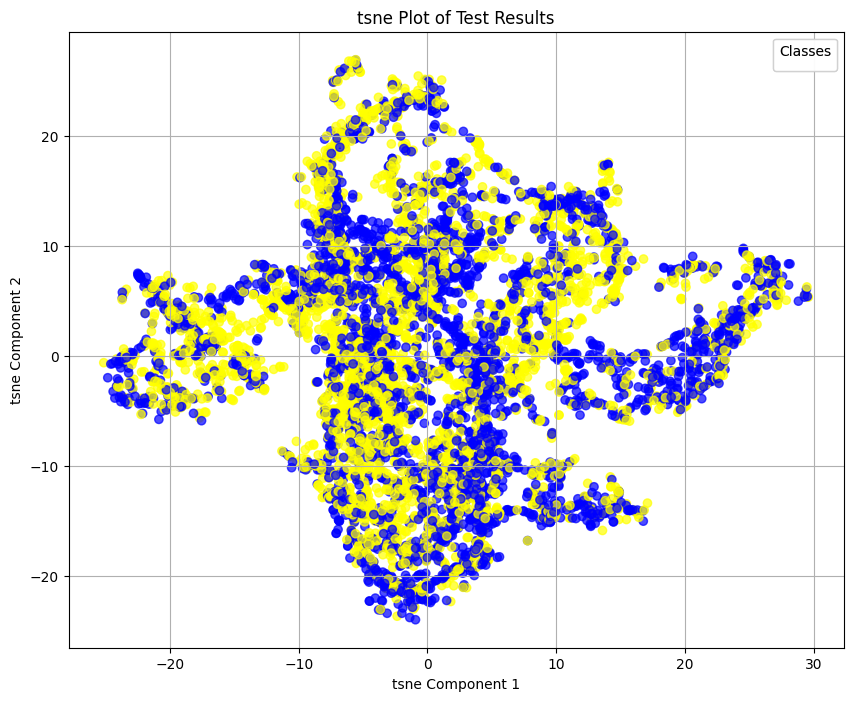

In [11]:
plot_tsne(test_results, algorithm="tsne")

/tmp/ipykernel_1002088/286735380.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(tsne_1, tsne_2, c=colours, cmap="viridis", alpha=0.7)
/home/eudald/Desktop/doctorat/connectome/venv/lib/python3.10/site-packages/matplotlib/collections.py:1109: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


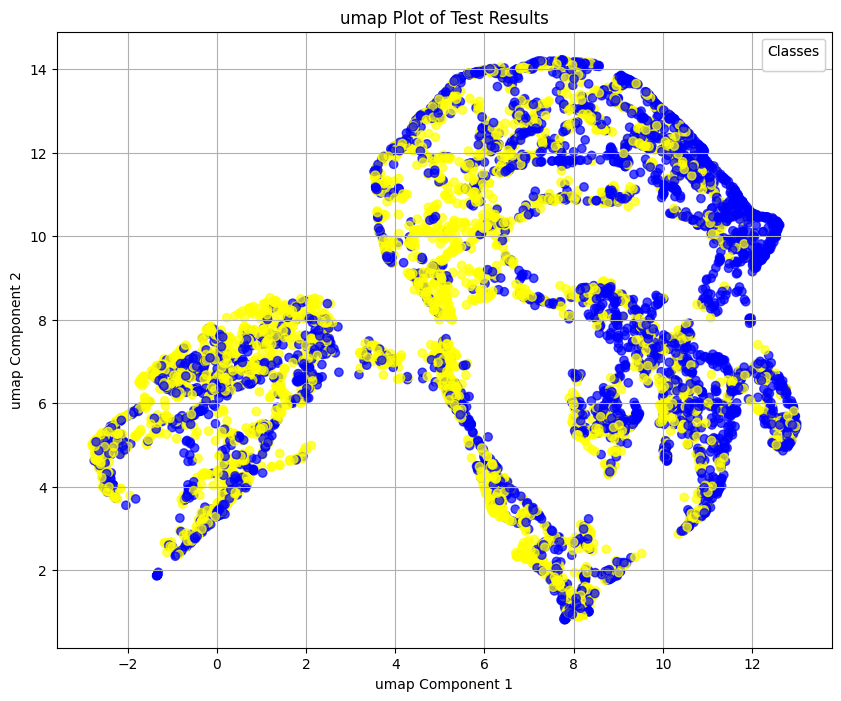

In [21]:
plot_tsne(test_results, algorithm="umap")

/tmp/ipykernel_1083831/286735380.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(tsne_1, tsne_2, c=colours, cmap="viridis", alpha=0.7)


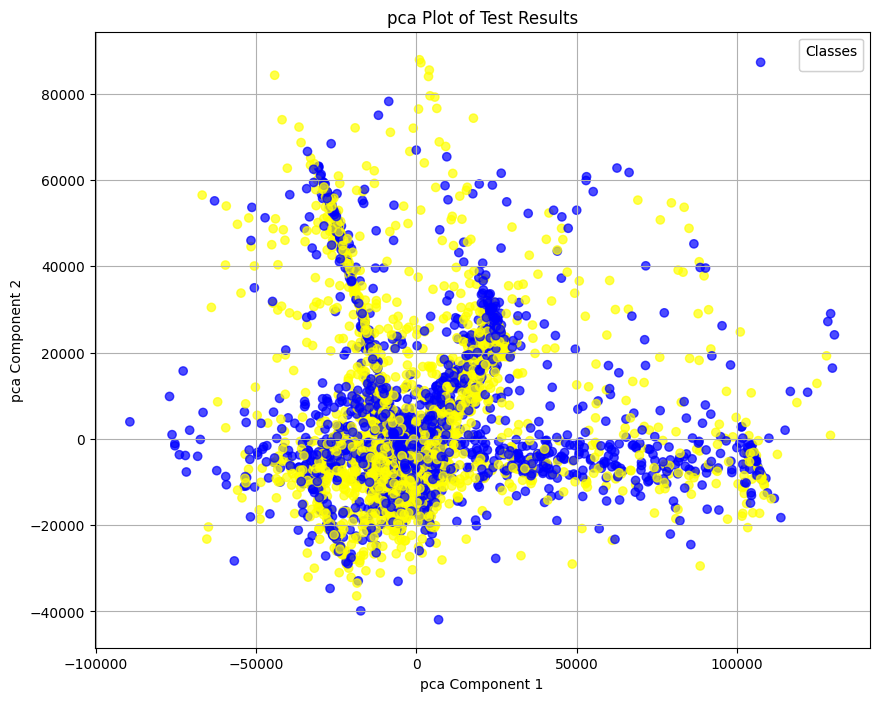

In [13]:
plot_tsne(test_results, algorithm="pca")

In [14]:
from manifold_plots import plot_manifold_3d

def plot_manifold_3d(test_results, geom="shape", algorithm="tsne"):
    if geom == "shape":
        shape_colors = {"circle": "blue", "star": "red"}
    elif geom == "colour":
        shape_colors = {"blue": "blue", "yellow": "yellow"}

    # Create the 3D scatter plot
    fig = go.Figure()

    # Add scatter3d trace for color coding
    for shape in test_results[geom].unique():
        df_shape = test_results[test_results[geom] == shape]
        fig.add_trace(
            go.Scatter3d(
                x=df_shape[f"{algorithm}_Component_1"],
                y=df_shape[f"{algorithm}_Component_2"],
                z=df_shape[f"{algorithm}_Component_3"],
                mode="markers",
                marker=dict(
                    size=2,
                    color=shape_colors[shape],
                    opacity=0.8,
                    line=dict(width=0),  # Remove the white border of the points
                ),
                name=shape,
            )
        )

    # Update layout to remove the background and set other properties
    fig.update_layout(
        scene=dict(
            xaxis=dict(backgroundcolor="rgba(0,0,0,0)", showgrid=False, zeroline=False),
            yaxis=dict(backgroundcolor="rgba(0,0,0,0)", showgrid=False, zeroline=False),
            zaxis=dict(backgroundcolor="rgba(0,0,0,0)", showgrid=False, zeroline=False),
        ),
        title=f"{algorithm.upper()} of Decision Making Neuron Activations",
        showlegend=True,
    )

    # Show the plot
    fig.show()

In [15]:
import plotly.graph_objects as go

plot_manifold_3d(test_results, geom="colour", algorithm="tsne")

In [16]:
plot_manifold_3d(test_results, geom="colour", algorithm="umap")

In [17]:
plot_manifold_3d(test_results, geom="colour", algorithm="pca")